In [19]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import torch
from data.datamodule import MNISTDatamodule, CIFAR10Datamodule, CIFAR100Datamodule, MNIST
from data.transforms import UnNormalize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
import seaborn as sns
palette = sns.color_palette()
sns.set_style("whitegrid")

In [180]:
from torchvision import transforms as T
from data.transforms import Permute

mnist_transform = T.Compose(
    [
        Permute([2, 0, 1]),
        T.Normalize(mean=[0.1307], std=[0.3081]),
        T.RandomHorizontalFlip(0.5)
    ]
)

cifar_transform = T.Compose(
    [
        Permute([2, 0, 1]),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        T.RandomHorizontalFlip(0.5)
    ]
)

unnormalize = UnNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [181]:
mnist_dm = MNISTDatamodule(
    train_transform=mnist_transform,
    inference_transform=mnist_transform,
    data_dir="./../data"
)
mnist_dm.prepare_data()
mnist_dm.setup()

cifar_dm = CIFAR10Datamodule(
    train_transform=cifar_transform,
    inference_transform=cifar_transform,
    data_dir="./../data"
)
cifar_dm.prepare_data()
cifar_dm.setup()

In [284]:
num_examples = 6
images = cifar_dm.train.data[:num_examples]
targets = cifar_dm.train.targets[:num_examples]
probs = torch.softmax(torch.rand(num_examples, 10), dim=1)

In [285]:
import numpy as np
BLUE, GREEN, YELLOW, RED = palette[0], palette[2], palette[8], palette[3]
def plot_probabilities(probs, target, labels, n_best=5, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    pred = probs.argmax().item()
    colors = [BLUE] * len(labels)
    if pred == target:
        colors[pred] = GREEN
    else:
        colors[pred] = RED
        colors[target] = YELLOW
        
    sorted_probs = sorted(probs, reverse=False)
    sorted_labels = [label for _, label in sorted(zip(probs, labels), reverse=False)]
    sorted_colors = [color for _, color in sorted(zip(probs, colors), reverse=False)]
    
    best_probs = np.array(sorted_probs[-n_best:])    
    best_labels = np.array(sorted_labels[-n_best:])
    best_colors = np.array(sorted_colors[-n_best:])
    
    hbars = ax.barh(best_labels, best_probs, color=best_colors, alpha=0.8)
    max_prob = max(best_probs)
    for i, bar in enumerate(hbars):
        ax.annotate(
            best_labels[i], 
            xy=(0.05*max_prob, bar.get_y() + bar.get_height() / 3), 
            xytext=(0, 0), 
            textcoords="offset points", 
            fontsize=12,
        )

    ax.bar_label(hbars, fmt='%.2f')
    ax.set_xlim(right=1.1*max_prob)  # adjust xlim to fit labels
    ax.grid(False)
    
def plot_images_predicted_probabilities(images, targets, probs, classes):
    fig, axes = plt.subplots(2, len(images), figsize=(18, 7), gridspec_kw={'height_ratios':[0.5, 1]})
    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])
    for i, (ax_top, ax_bottom) in enumerate(axes.T):
        ax_bottom.imshow(images[i])
        plot_probabilities(probs[i], targets[i], classes, ax=ax_top)
    plt.tight_layout()
    return fig

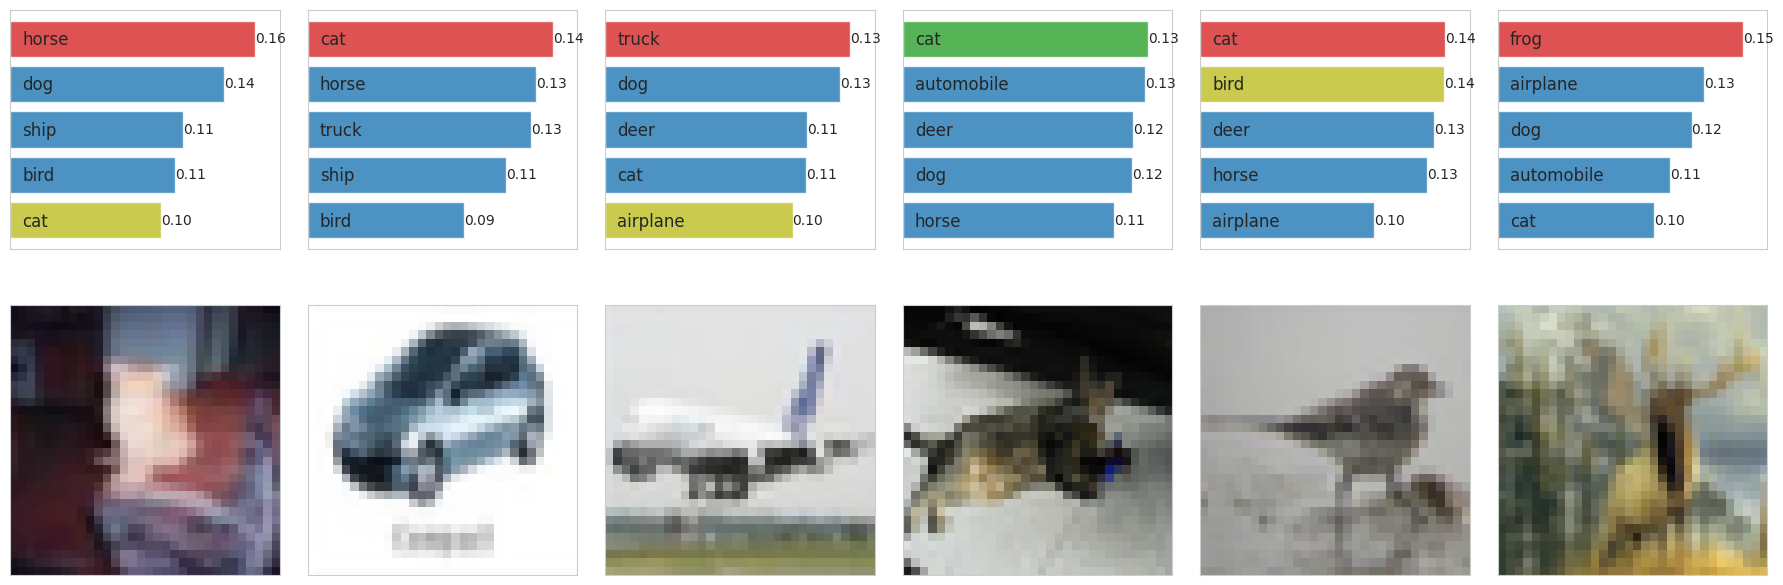

In [286]:
fig = plot_images_predicted_probabilities(images, targets, probs, classes=cifar_dm.classes)

In [314]:
import plotly.express as px

px.colors.qualitative.Plotly

['#636EFA',
 '#EF553B',
 '#00CC96',
 '#AB63FA',
 '#FFA15A',
 '#19D3F3',
 '#FF6692',
 '#B6E880',
 '#FF97FF',
 '#FECB52']

In [317]:
def plot_images_probabilities_plotly(images, targets, probs, labels, n_best=5):
    palette = px.colors.qualitative.Plotly
    fig = make_subplots(rows=2, cols=len(images), vertical_spacing=0.05, horizontal_spacing=0.05)
    for col, (img, target, prob) in enumerate(zip(images, targets, probs)):
        pred = prob.argmax().item()
        colors = [palette[0]] * len(labels)
        if pred == target:
            colors[pred] = palette[2]
        else:
            colors[pred] = palette[1]
            colors[target] = palette[0]
        sorted_probs = sorted(prob, reverse=False)
        sorted_labels = [label for _, label in sorted(zip(prob, labels), reverse=False)]
        sorted_colors = [color for _, color in sorted(zip(prob, colors), reverse=False)]

        best_probs = np.array(sorted_probs[-n_best:])    
        best_labels = np.array(sorted_labels[-n_best:])
        best_colors = np.array(sorted_colors[-n_best:])
        fig.add_bar(
            x=best_probs,
            y=best_labels,
            orientation='h',
            marker_color=best_colors,
            row=1,
            col=col+1,
            text=best_labels,
            textposition='inside',
            insidetextanchor="start",
            insidetextfont=dict(family='Arial', size=14, color='black'),
            outsidetextfont=dict(family='Arial', size=14, color='black'),
        )
        fig.add_image(z=img, zmin=[0]*4, zmax=[1]*4, row=2, col=col+1)
        fig.update_layout(showlegend=False, margin=dict(l=0, r=0, t=0, b=0))
        fig.update_xaxes(visible=False)
        fig.update_yaxes(visible=False)
    return fig

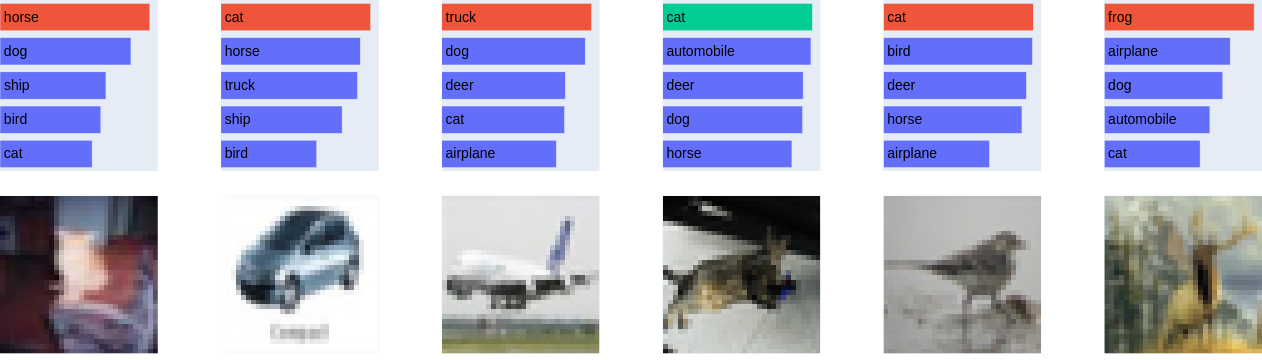

In [318]:
plot_images_probabilities_plotly(images, targets, probs, labels=cifar_dm.classes)